## Decision gradient

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.random as rd
import numpy as np

def f(x):
    return jnp.minimum((x-1)**2, (x+1)**2)

x = jnp.linspace(-4,4,1000)
y = jax.vmap(jax.grad(f))(x)
plt.plot(x,y)

def f1(theta, y, x):
    return 0.5*jnp.abs(y*jnp.exp(1j*theta) - x)**2

def g1(theta, y, x):
    return jnp.imag(jnp.conj(x)* y * jnp.exp(1j*theta))

x = 1.0 + 1j
y = 3 + 4j

jax.grad(f1)(1.0, y,x) - g1(1.0,y,x)

AttributeError: partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)

In [3]:
jnp.array([jnp.ones(10), jnp.zeros((10,)), jnp.zeros((10,)), jnp.ones(10)])   

DeviceArray([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

## np.unwrap

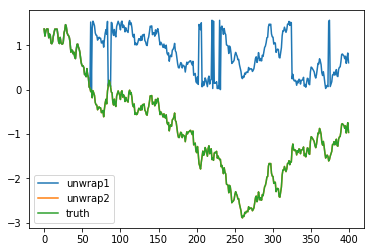

In [7]:
n1 = rd.normal(rd.PRNGKey(1), (400,))*0.1
theta =jnp.cumsum(n1) + jnp.pi/2
phi = theta % (jnp.pi/2)

theta1 = jnp.unwrap(phi, discont=jnp.pi/2)
theta2 = jnp.unwrap(4*phi) / 4

plt.plot(theta1, label='unwrap1')
plt.plot(theta2, label='unwrap2')
plt.plot(theta, label='truth')
plt.legend()

In [9]:
pip show jax


The following command must be run outside of the IPython shell:

    $ pip show jax

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


## DDPLL

In [44]:
import jax, jax.numpy as jnp, matplotlib.pyplot as plt, jax.random as rd,numpy as np
from optical_flax.dsp import cpr, bps, ddpll
from optical_flax.fiber_tx import QAM
from optical_flax.fiber_system import Tx_data
from optical_flax.utils import show_symb
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.30'
from jax.config import config
config.update("jax_enable_x64", False)


## Step 1: data
M = 16
mod = QAM(M)
constSymb = mod.constellation / jnp.sqrt(mod.Es)
sigWDM, symbWDM, param = Tx_data(rd.PRNGKey(0), 1, Nmodes=1, Power=0,Nch=3, SpS=32, Nbits=int(np.log2(M))*4000, Rs=190e9, freq_space=220e9, M=M)
truth = jax.device_get(symbWDM[:,0,:])
n1 = rd.normal(rd.PRNGKey(0), truth.shape, dtype=jnp.float64)*0.02
n2 = rd.normal(rd.PRNGKey(1), truth.shape, dtype=jnp.complex128)*0.1
pn = jnp.cumsum(n1, axis=0)
y = truth * jnp.exp(1j*pn) + n2


Sample rate fa: 6.08e+12, Cut off frequency fc: 3.3e+11, fa > 2fc: True
Transmitter is working..
signal shape: (128000, 1), symb shape: (4000, 3, 1)
 Tx_data complete, time cost(s):4.955164194107056


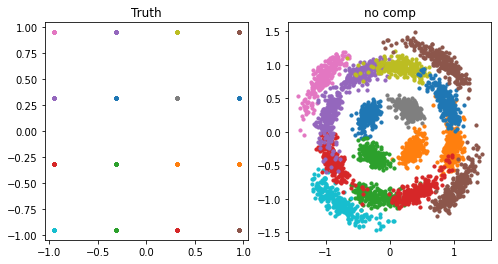

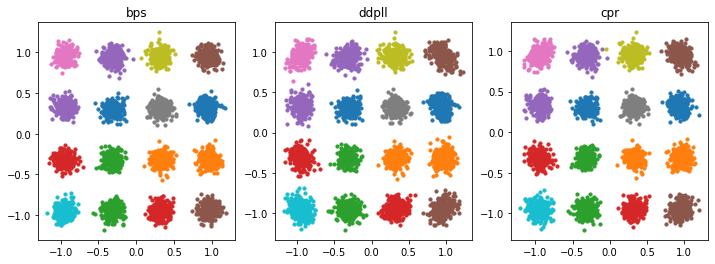

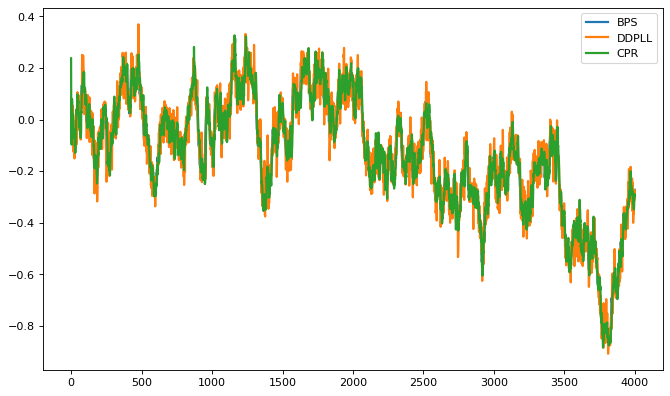

In [ ]:

## Step 2: Adaptive filter
## BPS
y_rec = {}
theta = {}
y_rec['bps'], theta['bps'] = bps(jax.device_get(y),5, jax.device_get(constSymb), 101)

## DDPLL
tau1 = 1 / (2 * np.pi * 10e6)
tau2 = 1 / (2 * np.pi * 10e6)
y_rec['ddpll'], theta['ddpll'] = ddpll(jax.device_get(y), 0.5, constSymb, truth)


## CPR
y_rec['cpr'], theta['cpr'] = cpr(jax.device_get(y), 7, jax.device_get(constSymb), jax.device_get(truth))



## Step 3: show symbol

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
show_symb(truth[:,0], jax.device_get(truth[:,0]))
plt.title('Truth')
plt.subplot(1,2,2)
plt.title('no comp')
show_symb(y[:,0], jax.device_get(truth[:,0]))


rec = ['bps','ddpll','cpr']
plt.figure(figsize=(12,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    show_symb(y_rec[rec[i-1]][:,0], jax.device_get(truth[:,0]))
    plt.title(rec[i-1])

plt.figure(figsize=(10,6),dpi=80)
plt.plot(theta['bps'][0:10000], label='BPS',linewidth=2)
plt.plot(theta['ddpll'][0:10000], label='DDPLL',linewidth=2)
plt.plot(theta['cpr'][0:10000], label='CPR',linewidth=2)
plt.legend()

## OPT_Cell and meta learning

In [ ]:
import flax.linen as nn 
from typing import Any
import optax
import warnings
warnings.filterwarnings("ignore")

def sigmoid_init(key, lr):
    return -jnp.log(1. / lr - 1)



class OPT_cell(nn.Module):
    opt:Any=optax.inject_hyperparams(optax.adam)(learning_rate=0.1)
    init_lr:float=0.01

    def f(self, theta,x):
        return theta*x

    def loss(self, theta, x, y):
        y_hat = self.f(theta, x)
        return jnp.mean((y - y_hat)**2)/2, y_hat
    

    @nn.compact
    def __call__(self, h, inputs):
        theta,state = h
        x,y = inputs
        eta = self.param('eta', sigmoid_init, self.init_lr)
        bf_b1 = self.param('b1', sigmoid_init, 0.9)
        bf_b2 = self.param('b2', sigmoid_init, 0.999)
        state.hyperparams['learning_rate'] = jax.nn.sigmoid(eta)
        state.hyperparams['b1'] = jax.nn.sigmoid(bf_b1)
        state.hyperparams['b2'] = jax.nn.sigmoid(bf_b2)
        grads,y_hat = jax.grad(self.loss, has_aux=True)(theta, x, y)
        updates, state = self.opt.update(grads, state)
        theta = optax.apply_updates(theta, updates)
        return (theta, state),  y_hat

    
    def initialize_carry(self):
        theta = jnp.ones(1)
        state = self.opt.init(theta)
        return theta, state

   
x = rd.normal(rd.PRNGKey(1), (10,1))
y = 10*x + rd.normal(rd.PRNGKey(2), (10,1))*0.1

In [ ]:
PE = nn.scan(OPT_cell, variable_broadcast="params",split_rngs={'params':False}, in_axes=0, out_axes=0)
h = OPT_cell() .initialize_carry() # theta, state
OPT = PE()
param = OPT.init(rd.PRNGKey(1), h,(x,y))

meta_opt = optax.adam(learning_rate=0.05)
meta_state = meta_opt.init(param)

def outer_loss(param,h,OPT):
    h, y_hat = OPT.apply(param, h, (x,y))
    return jnp.mean((y - y_hat)**2), h

@jax.jit
def outer_loop(state, xs):
    param, h, meta_state = state
    (l,h), grads = jax.value_and_grad(outer_loss, has_aux=True)(param, h, OPT)
    updates,meta_state = meta_opt.update(grads, meta_state)
    param = optax.apply_updates(param, updates)
    return (param, h, meta_state), (param, h[0],l)

(param, h, meta_state), (history,theta,l) = jax.lax.scan(outer_loop, (param, h, meta_state), jnp.ones(1000))

Text(0.5, 1.0, 'b2')

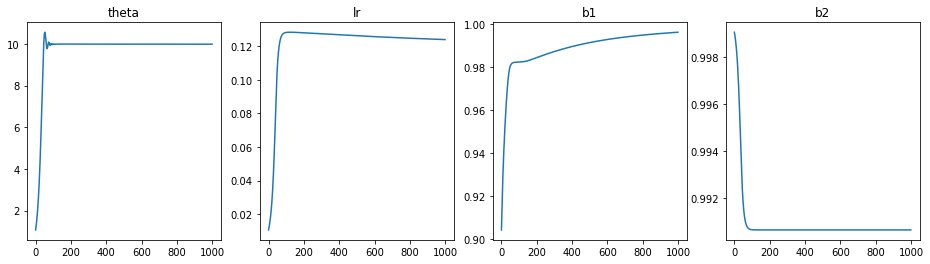

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.title('theta')
plt.plot(theta)
plt.subplot(1,4,2)
plt.plot(jax.nn.sigmoid(history['params']['eta']))
plt.title('lr')
plt.subplot(1,4,3)
plt.plot(jax.nn.sigmoid(history['params']['b1']))
plt.title('b1')
plt.subplot(1,4,4)
plt.plot(jax.nn.sigmoid(history['params']['b2']))
plt.title('b2')

## DDPLL

In [ ]:
## Step 1: data
M = 16
mod = QAM(M)
constSymb = mod.constellation / jnp.sqrt(mod.Es)
sigWDM, symbWDM, param = Tx_data(rd.PRNGKey(0), 1, Nmodes=1, Power=0,Nch=3, SpS=32, Nbits=int(np.log2(M))*40000, Rs=190e9, freq_space=220e9, M=M)
truth = jax.device_get(symbWDM[:,0,:])
n1 = rd.normal(rd.PRNGKey(0), truth.shape, dtype=jnp.float64)*0.04
n2 = rd.normal(rd.PRNGKey(1), truth.shape, dtype=jnp.complex128)*0.1
pn = jnp.cumsum(n1, axis=0)
y = truth * jnp.exp(1j*pn) + n2


from optical_flax.operator import frame
xs = frame(y, 20, 20)
ys = frame(truth, 20,20)
dataset = (xs,ys)

Sample rate fa: 6.08e+12, Cut off frequency fc: 3.3e+11, fa > 2fc: True
Transmitter is working..
signal shape: (1280000, 1), symb shape: (40000, 3, 1)
 Tx_data complete, time cost(s):1.072204351425171


In [ ]:
class PE_cell(nn.Module):
    opt:Any=optax.inject_hyperparams(optax.sgd)(learning_rate=0.5, momentum=0.1)
    init_lr:float=0.1
    init_momentum:float=0.1

    def f(self, theta, x):
        # Phase rotation
        return jnp.exp(1j*theta)*x

    def loss(self, theta, x):
        # MSE
        y_hat = self.f(theta, x)
        return jnp.min(jnp.abs(constSymb - y_hat)**2), y_hat
    

    @nn.compact
    def __call__(self, h, x):
        theta,state = h
        eta = self.param('eta', sigmoid_init, self.init_lr)
        m = self.param('momentum', sigmoid_init, self.init_momentum)
        state.hyperparams['learning_rate'] = jax.nn.sigmoid(eta)
        state.hyperparams['momentum'] = jax.nn.sigmoid(m)
        grads, y_hat  = jax.grad(self.loss,has_aux=True)(theta, x)
        updates, state = self.opt.update(grads, state)
        theta = optax.apply_updates(theta, updates)
        return (theta, state),  y_hat

    
    def initialize_carry(self):
        theta = jnp.zeros(1)
        state = self.opt.init(theta)
        return theta, state


In [ ]:
DDPLL = nn.scan(PE_cell, variable_broadcast="params",split_rngs={'params':False}, in_axes=0, out_axes=0)
h = PE_cell().initialize_carry()  # theta, opt_state
ddpll = DDPLL()
param = ddpll.init(rd.PRNGKey(1), h, xs[0])

meta_opt = optax.adam(learning_rate=0.001)
meta_state = meta_opt.init(param)

def outer_loss(param,h,xs,ys, OPT):
    h, y_hat = OPT.apply(param, h, xs)
    return jnp.mean(jnp.abs(ys - y_hat)**2), h

@jax.jit
def outer_loop(state, data):
    xs,ys = data
    param, h, meta_state = state
    (l,h), grads = jax.value_and_grad(outer_loss, has_aux=True)(param, h, xs,ys,ddpll)
    updates,meta_state = meta_opt.update(grads, meta_state)
    param = optax.apply_updates(param, updates)
    return (param, h, meta_state), (param, h[0],l)

(param, h, meta_state), (history,theta,l) = jax.lax.scan(outer_loop, (param, h, meta_state),  dataset)

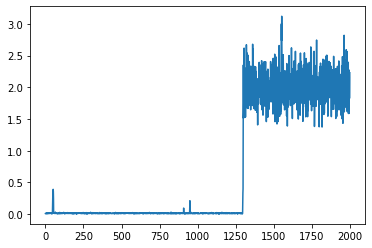

In [ ]:
plt.plot(l)

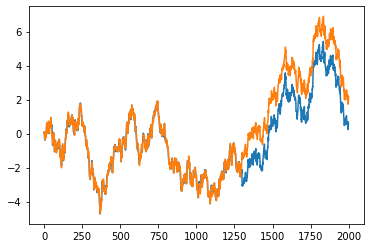

In [ ]:
plt.plot(-theta)
plt.plot(pn[::20])

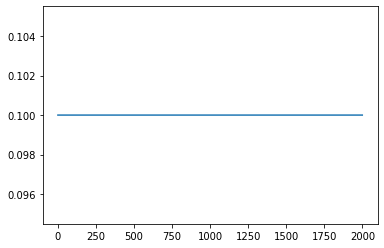

In [ ]:
plt.plot(jax.nn.sigmoid(history['params']['eta']))

## DDLMS

In [ ]:
import commplax.adaptive_filter as af
from commplax.module.core import Signal, SigTime, dict_replace
from optical_flax.layers import mimoaf
from functools import partial
config.update("jax_enable_x64", False)
init, update, apply = af.ddlms(train=True)
ys = Signal(y, t=SigTime(0,0,1))

In [ ]:
net = mimoaf(taps=3,sps=1, mimofn=partial(af.ddlms, lr_w=0.01, lr_f=0.01, lr_b=0.01))
state = net.init(rd.PRNGKey(0), ys)
# state = dict_replace(state, {'truth':truth})

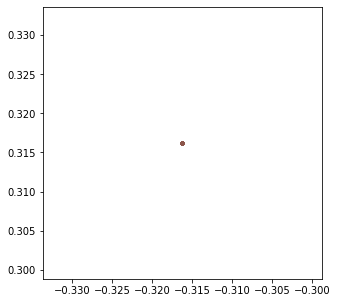

In [ ]:
y1,s1 = net.apply(state, ys, mutable={'af_state'})
plt.figure(figsize=(5,5))
show_symb(y1.val,truth[1:-1,0])

In [ ]:
import flax.linen as nn
class DDPLL(nn.Module):
    @nn.compact
    def __call__(self, signal):
        x,t = 

(3996,)

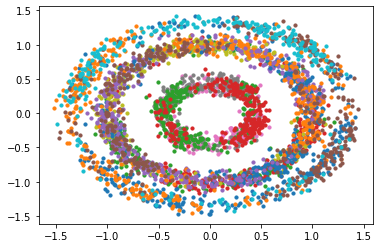

In [ ]:
show_symb(y[:,0],truth[:,0])

In [15]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50'
import warnings
warnings.filterwarnings("ignore")

import jax, optax, jax.random as rd, jax.numpy as jnp, flax.linen as nn, numpy as np, matplotlib.pyplot as plt
from optical_flax.dsp import simple_dsp, mimo_dsp
from optical_flax.fiber_system import get_data
import matplotlib.pyplot as plt
import optical_flax.base as base
import optax
from gdbp import gdbp_base as gb, data as gdat, aux
import pickle
from optical_flax.fiber_system import Rx_data



path_tr =  '/home/xiaoxinyu/data/0912train_dz_2m'
path_ts = '/home/xiaoxinyu/data/0912test_dz_2m'
p = 3.0

# train data
path_tx = path_ts + f'/Tx_ch19_power{p}'
path_rx = path_ts + f'/Channel_ch19_power{p}_dz0.002'
x_batch, symbWDM, param = pickle.load(open(path_tx, 'rb'))
y_batch, paramCh = pickle.load(open(path_rx, 'rb'))
num = 0
data_sml_tr, paramRx, noise = Rx_data(rd.PRNGKey(0), y_batch[num,:,None], symbWDM[num], 2, param=param, paramCh=paramCh, FO=0, lw=0)

# test data
num = 2
data_sml_ts, paramRx, noise = Rx_data(rd.PRNGKey(0), y_batch[num,:,None], symbWDM[num], 2, param=param, paramCh=paramCh, FO=0, lw=0)

print(f'data.y.shape:{data_sml_tr.y.shape}')

# Define optimizer
# lr1 = optax.piecewise_constant_schedule(1e-4,{2000:1e-5, 4000:1e-6})
lrD = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=1e-4,warmup_steps=100,decay_steps=4000,end_value=1e-6)
lrN = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=1e-4,warmup_steps=100,decay_steps=4000,end_value=1e-6)
lrO = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=1e-3,warmup_steps=100,decay_steps=4000,end_value=1e-6)

# tx = optax.adam(learning_rate=lr2)
# tx = optax.adamw(learning_rate=lr2, weight_decay=0.01)
# tx = optax.chain(
#   optax.clip(1.0),
#   optax.adamw(learning_rate=schedule,weight_decay=0.0001),
# )

def fn(k,v):
    if k == 'dispersion_kernel':
        return 'D'
    elif k == 'nonlinear_kernel':
        return 'NL'
    else:
        return 'normal'

from flax.core.frozen_dict import FrozenDict

def map_nested_fn(fn):
  '''Recursively apply `fn` to the key-value pairs of a nested dict'''
  def map_fn(nested_dict):
    return FrozenDict({k: (map_fn(v) if isinstance(v, FrozenDict) else fn(k, v))
            for k, v in nested_dict.items()})
  return map_fn

label_fn = map_nested_fn(fn)
tx = optax.multi_transform({'D':optax.adam(learning_rate=lrD), 'NL':optax.adam(learning_rate=lrN), 'normal':optax.adam(learning_rate=lrO), 'bias':optax.adam(learning_rate=lrO)}, label_fn)
# tx = optax.adam(learning_rate=lrO)

## define model
batch_size = 100
sparams_flatkeys = [] # [('DBP',)]  # [('DBP',)] # [('DBP',),('RConv',), ('final layer',)]
steps = 5
k = int(1600*(25/steps))
dtaps =  k + (k%2) + 1
ntaps = 5
rtaps = 41 
xi = 0.1
NL = True # use nonlinear layer or not.
model_train = base.model_init(data_sml_tr, init_len=60000, sparams_flatkeys=sparams_flatkeys, mode='train', steps=steps, xi=xi,  dtaps=dtaps, ntaps=ntaps, rtaps=rtaps, nonlinear_layer=NL)  
model_test = base.model_init(data_sml_ts, init_len=60000, sparams_flatkeys=sparams_flatkeys, mode='test', steps=steps, xi=xi, dtaps=dtaps, ntaps=ntaps, rtaps=rtaps, nonlinear_layer=NL)  

# Training FDBP Model on a single signal 
gen = base.train(model_train, data_sml_tr, batch_size=batch_size, n_iter=6000, tx=tx)
loss0, Train0 = base.run_result(gen)
print('Final train loss:',loss0[-1])
np.save('loading/loss0', loss0)
pickle.dump(Train0[-1].params, open('loading/params','wb'))

 Rx_data complete, time cost(s):0.1047508716583252
 Rx_data complete, time cost(s):0.05819225311279297
data.y.shape:(200000, 1)


training:   0%|          | 0/6000 [00:00<?, ?it/s]

Final train loss: 0.044093847


In [22]:
from optical_flax.operator import L2
L2(data_sml_tr.y)

DeviceArray(1., dtype=float32)

In [17]:
# test model
metric1,sig_list = base.test(model_test, Train0[-1].params, data_sml_tr, eval_range=(100,-100))
metric2,sig_list = base.test(model_test, Train0[-1].params, data_sml_ts, eval_range=(100,-100))

# train BER
print('\n training metric \n')
print(metric1)

# test BER
print('\n testing metric \n')
print(metric2)


 training metric 

           BER       QSq        SNR
dim0   0.00987  7.351838  14.143612
total  0.00987  7.351838  14.143612

 testing metric 

            BER       QSq        SNR
dim0   0.010863  7.216139  13.993121
total  0.010863  7.216139  13.993121


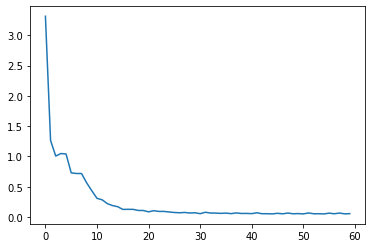

In [13]:
plt.plot(loss0)

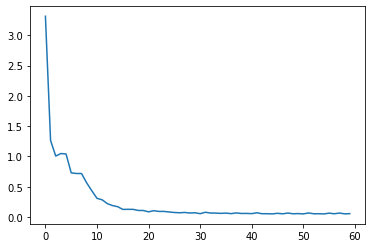

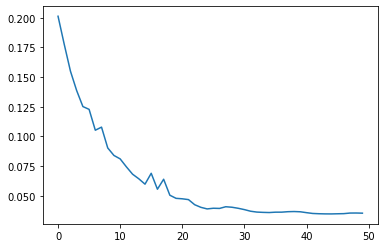

In [14]:
tl = []
for i in range(60):
    metric2,sig_list = base.test(model_test, Train0[i].params, data_sml_ts, eval_range=(100,-100))
    tl.append(metric2['BER']['dim0'])
    
plt.plot(loss0[:])

plt.figure()
plt.plot(tl[10:])

In [51]:
import numpy  as np
from scipy.special import erfc, erfcinv
import matplotlib.pyplot as plt

p = [-3.0, 0.0, 3.0, 6.0]
steps = [1,2,3,4,5,6,7,8,10,20]
ber_tr = {}
ber_ts = {}

ber_tr = np.ones([4,10])
ber_ts = np.ones([4,10])

for i in range(4):
    for j in range(10):
        ber_tr[i,j] = np.load(f'loading/metric_train_power{p[i]}_steps{steps[j]}.npy')[0,0]
        ber_ts[i,j] = np.load(f'loading/metric_test_power{p[i]}_steps{steps[j]}.npy')[0,0]

def Q_factor(ber):
    return 20*np.log10(np.sqrt(2)*erfcinv(2*ber))

In [12]:
ber_ts[3,:]

array([0.48789864, 0.50015007, 0.05478569, 0.05070182, 0.05057475,
       0.04973053, 0.04800373, 0.04682551, 0.04633142, 0.05847063])

/tmp/ipykernel_46843/377838015.py:19: RuntimeWarning: invalid value encountered in log10
  return 20*np.log10(np.sqrt(2)*erfcinv(2*ber))


Text(0, 0.5, 'Q factor')

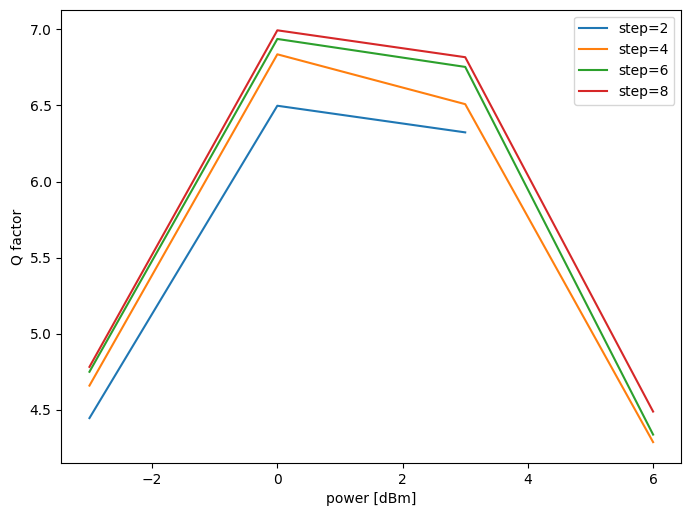

In [35]:
plt.figure(figsize=(8,6), dpi=100)
for i in [1,3,5,7]:
    plt.plot(p, Q_factor(ber_ts[:,i]), label=f'step={steps[i]}')
plt.legend()
plt.xlabel('power [dBm]')
plt.ylabel('Q factor')


Text(0.5, 0, 'iters/(100)')

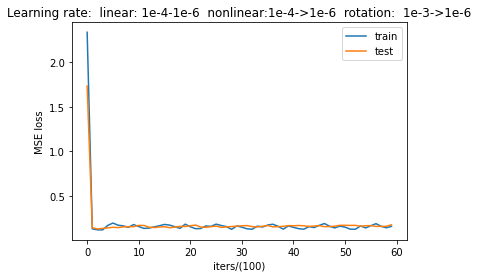

In [49]:
import numpy  as np
from scipy.special import erfc, erfcinv
import matplotlib.pyplot as plt
l  = np.load(f'loading/train_loss.npy')
tl = np.load(f'loading/test_loss.npy')
plt.plot(l[:], label='train')
plt.plot(tl[:], label='test')
plt.legend()
plt.title('Learning rate:  linear: 1e-4-1e-6  nonlinear:1e-4->1e-6  rotation:  1e-3->1e-6')
plt.ylabel('MSE loss')
plt.xlabel('iters/(100)')

Text(0.5, 1.0, 'lr schedule: 1e-3->1e-6')

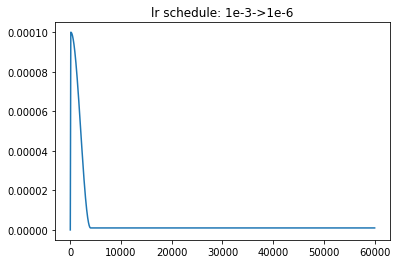

In [42]:
lrD = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=1e-4,warmup_steps=100,decay_steps=4000,end_value=1e-6)
plt.plot(lrD(np.arange(60000)))
plt.title('lr schedule: 1e-3->1e-6')

In [53]:
Q_factor(0.02)

6.250946921615003